# 01-Data Preparation

This notebook is just looking at the raw data, downloading it and getting it in the right shape.

#### Requirements

*Note-to-self:* Here's a list of things to keep in mind when going through the data/analysis.

- Yekaterinburg, RU needs GPS coordinates adjusted to `(56.8, 60.6)`.
- `15-Jul` -> yr. 2015

- Some projects/classifications will need links added.

In [46]:
# Project variables
data_dir = '../data/'

btl_f = data_dir + 'BTL-data.json'

In [47]:
# Libraries
import pandas as pd
import json

%matplotlib inline

In [48]:
# Read in the ArcGIS data
with open(btl_f) as data_file:    
    data = json.load(data_file)

In [49]:
data.keys()

dict_keys(['layers', 'showLegend', 'visibility', 'opacity'])

In [50]:
layers = data['layers'][0]

In [51]:
print("Layer keys: {}".format(layers.keys()))

layers['featureSet'].keys()

Layer keys: dict_keys(['layerDefinition', 'featureSet', 'nextObjectId', 'popupInfo'])


dict_keys(['features', 'geometryType'])

In [52]:
features = layers['featureSet']['features']

print ("{} many features included.".format(len(features)))

316 many features included.


In [53]:
features[0]

{'attributes': {'BTL_Year': '8-Jul',
  'BTL_status': 'Student',
  'City_of_Residence_during_BTL*': 'Adonis Zouk Mosbeh',
  'Country_of_Residence_during_BTL': 'Lebanon',
  'First_Name': 'Eliane',
  'Last_Name': 'Aoun',
  'Latitude': 33.955,
  'Longitude': 35.61472,
  '__OBJECTID': 0},
 'geometry': {'spatialReference': {'wkid': 102100},
  'x': 3964612,
  'y': 4022761}}

In [54]:
filt_features = [x['attributes'] for x in features]
df = pd.DataFrame(filt_features)

df.drop('__OBJECTID', axis=1, inplace=True,)
df.head()

,BTL_Year,BTL_status,City_of_Residence_during_BTL*,Country_of_Residence_during_BTL,First_Name,Last_Name,Latitude,Longitude
0,8-Jul,Student,Adonis Zouk Mosbeh,Lebanon,Eliane,Aoun,33.95500,35.61472
1,8-Jul,Student,Kuwait,Jordan,Hiba,as-Masri,29.36972,47.97833
2,8-Jul,Student,Bazourieh,Lebanon,Ali,Awarke,33.25389,35.27167
3,8-Jul,Student,Kufur Yassif,Israel,Randa,Ghantous,32.95472,35.16528
4,8-Jul,Student,Amman,Jordan,Karim,Ghawi,31.94972,35.93278


#### Format the `BTL_Year`

In [55]:
df.BTL_Year.unique()

array(['8-Jul', '9-Jul', '10-Jul', '11-Jul', '12-Jul', '13-Jul', '14-Jul',
       '17-Jul', '15-Jul', '16-Jul'], dtype=object)

In [56]:
# add zeroes so the date can be formatted
df['BTL_Year'] = df['BTL_Year'].str.zfill(6)

df['BTL_Year'] = pd.to_datetime(df.BTL_Year, format='%y-%b')

# change 2008-07-01 -> 2008
df['BTL_Year'] = df['BTL_Year'].map(lambda x: x.year)

df.BTL_Year.head()

0    2008
1    2008
2    2008
3    2008
4    2008
Name: BTL_Year, dtype: int64

#### Rename Columns

Something human readable, prefferably.

In [57]:
new_cols = ['year', 'status', 'city',
           'country', 'first_name', 'last_name',
           'lat', 'long']
df.columns = new_cols

df.head(2)

,year,status,city,country,first_name,last_name,lat,long
0,2008,Student,Adonis Zouk Mosbeh,Lebanon,Eliane,Aoun,33.95500,35.61472
1,2008,Student,Kuwait,Jordan,Hiba,as-Masri,29.36972,47.97833


---

Years: [2008 2009 2010 2011 2012 2013 2014 2017 2015 2016]


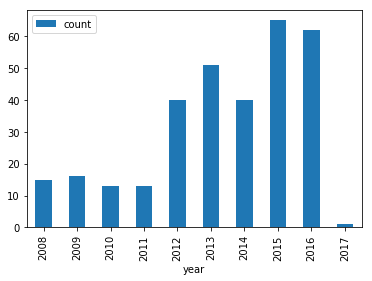

In [58]:
print ("Years: {}".format(df.year.unique()))

# Years plot, get cnts
yrs = df.year.value_counts().reset_index()
# rename for ease
yrs.columns = ['year', 'count']
# Sort by natural intuition
yrs.sort_values('year', inplace=True)

# plot it !
yrs.plot(kind='bar', x='year', y='count')

---

In [59]:
print ("Statuses: {}".format(df.status.unique()))


statuses = df['status'].value_counts()
statuses

Statuses: ['Student' 'Chaperone' 'Faculty' 'NSPP Mentor']


Student        264
Chaperone       28
Faculty         22
NSPP Mentor      2
Name: status, dtype: int64

#### Format Country Names

In [60]:
df.country.nunique()

40

In [61]:
df.country.value_counts()

Russia                                 57
USA                                    50
U.S.                                   25
US                                     22
Lebanon                                15
Jordan                                 14
Morocco                                13
Israel                                 12
Bahrain                                12
Egypt                                  12
Turkey                                  7
Syria                                   7
Tunisia                                 7
Armenia                                 7
Algeria                                 5
West Bank                               3
Kyrgyzstan                              3
Sri Lanka                               3
Bulgaria                                3
Saudi Arabia                            3
Palestine                               3
Canada                                  3
Pakistan                                3
India                             

In [79]:
country_aliases = {
    'USA': 'United States of America',
    'U.S.': 'United States of America',
    'US': 'United States of America',
    'Kuwait (but she is Lebanese)': 'Kuwait',
    'Syria ': 'Syria',
    'Palestinian Territories': 'Palestine',
    'Palestinian Territories ': 'Palestine'
}

df['country'] = df['country'].map(lambda x: country_aliases[x] if x in country_aliases else x)

#### String Formatting

Remove all of the quotes, paratheses, and nastiness from the dataset.

In [82]:
def clean_col(column, junk_str):
    """
    Removes an unwanted character from a Pandas DF column/series
    """
    column = column.str.replace(junk_str, '')
    return column

In [83]:
# For each column, and for each junk str, remove it!
for col in ['city', 'country', 'first_name', 'last_name']:
    for junk in ['"', "'", '?',r"\(.*\)"]:
        df[col] = clean_col(df[col], junk)

In [84]:
df.iloc[:200]

,year,status,city,country,first_name,last_name,lat,long
0,2008,Student,Adonis Zouk Mosbeh,Lebanon,Eliane,Aoun,33.95500,35.61472
1,2008,Student,Kuwait,Jordan,Hiba,as-Masri,29.36972,47.97833
2,2008,Student,Bazourieh,Lebanon,Ali,Awarke,33.25389,35.27167
3,2008,Student,Kufur Yassif,Israel,Randa,Ghantous,32.95472,35.16528
4,2008,Student,Amman,Jordan,Karim,Ghawi,31.94972,35.93278
5,2008,Student,Jerusalem,Israel,Ehab,Ghosheh,31.78333,35.21667
6,2008,Student,Amman,Jordan,Faris,Jaber,31.94972,35.93278
7,2008,Chaperone,,Jordan,Hiyam,Mahmoud,31.24000,36.51000
8,2008,Chaperone,,Jordan,Reina,Mina,31.24000,36.51000
9,2008,Student,Ramallah,Palestine,Qais,Mousa,31.90000,35.20000


#### Country Counts

In [91]:
print ("Unique Countries:")
print (df.country.unique().tolist())

# Years plot, get cnts
country_cnts = df.country.value_counts().reset_index()
# rename for ease
country_cnts.columns = ['country', 'count']

# sort 
country_cnts.sort_values('count', ascending=False, inplace=True)

Unique Countries:
['Lebanon', 'Jordan', 'Israel', 'Palestine', 'Syria', 'West Bank', 'Bahrain', 'Saudi Arabia', 'Oman', 'Gaza', 'Libya', 'Algeria', 'Egypt', 'Morocco', 'Tunisia', 'Bulgaria', 'United States of America', 'Russia', 'Canada', 'Yemen', 'Kuwait', 'Sudan', 'France', 'Turkey', 'Iraq', 'Armenia', 'China', 'Bangladesh', 'Sri Lanka', 'Pakistan', 'Nepal', 'India', 'Kyrgyzstan']


In [92]:
country_cnts

,country,count
0,United States of America,97
1,Russia,57
2,Lebanon,15
3,Jordan,14
4,Morocco,13
5,Egypt,12
6,Israel,12
7,Bahrain,12
8,Palestine,9
9,Syria,8


In [86]:
df.to_csv((data_dir + 'canonical/student_data.csv'), index=False)

In [94]:
country_cnts.to_csv((data_dir + 'canonical/country_counts.csv'), index=False)